# HW6 Jiahao Sun 7438675766

In [3]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,roc_auc_score,confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from scipy.special import softmax
from sklearn.cluster import KMeans
from statistics import mode
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

## 1

## (a)

In [2]:
wdbc_data_path = "../data/wdbc.data"
wdbc_name_path = "../data/wdbc.names"
wdbc_data = pd.read_csv(wdbc_data_path, header=None)
wdbc_data.columns = ['id', 'label'] + ['feat%d'%i for i in range(1, wdbc_data.shape[1] - 2 + 1)]
wdbc_data.replace({'B' : 0, 'M' : 1}, inplace=True)

In [3]:
wdbc_data

,id,label,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## (b)

In [4]:
def split_train_test(data, random_state):
    test_size=0.2
    np.random.seed(random_state)
    
    # select 20% from 0 class (benign class)
    b_idx, = np.where(data['label'] == 0)
    b_test_num = round(len(b_idx) * test_size)
    b_test_idx = np.random.choice(b_idx, b_test_num, replace=False)
    
    # select 20% from 1 class (malignant class)
    m_idx, = np.where(data['label'] == 1)
    m_test_num = round(len(m_idx) * test_size)
    m_test_idx = np.random.choice(m_idx, m_test_num, replace=False)
    
    test_idx = np.concatenate([b_test_idx, m_test_idx])
    train_idx = np.array([i for i in range(data.shape[0]) if i not in test_idx])
    trainX = data.iloc[train_idx, 2:].copy()
    trainY = data.iloc[train_idx, 1].copy()
    testX = data.iloc[test_idx, 2:].copy()
    testY = data.iloc[test_idx, 1].copy()
    
    return trainX, trainY, testX, testY

In [10]:
def normalize(X_train,X_test):
    mms = MinMaxScaler()
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)
    return X_train,X_test

## (b)i

In [6]:
tuned_params = {'C' : np.logspace(-2, 7, 20)}
    
#ettings of grid search
settings = {
    'param_grid' : tuned_params, 
    'scoring' : 'f1_weighted',
    'n_jobs' : -1,
    'verbose' : 0}

#initialize result dataframe
train_resdf = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score', 'auc'])
test_resdf = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score', 'auc'])

In [7]:
# 30 times Monte-Carlo Simulation
for i in range(30):
    trainX, trainY, testX, testY = split_train_test(wdbc_data, random_state=i)
    trainX, testX = normalize(trainX, testX)

    #5-fold cross-validation
    settings['cv'] = StratifiedKFold(5, random_state=i, shuffle=True)
    clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **settings)
    clf.fit(trainX, trainY)

    # predict and evaluate the model
    trainPredY_prob = clf.decision_function(trainX)
    trainPredY = clf.predict(trainX)
    acc_train = accuracy_score(trainY, trainPredY)
    precision = precision_score(trainY, trainPredY, pos_label=1)
    recall = recall_score(trainY, trainPredY, pos_label=1)
    f1score = f1_score(trainY, trainPredY, pos_label=1, average='weighted')
    auc_train = roc_auc_score(trainY, trainPredY_prob)
    tmp_train_result = {
        'accuracy' : acc_train,
        'precision' : precision,
        'recall' : recall,
        'f1-score' : f1score,
        'auc' : auc_train}
    train_resdf = train_resdf.append(tmp_train_result, ignore_index=True)

    testPredY_prob = clf.decision_function(testX)
    testPredY = clf.predict(testX)
    acc_test = accuracy_score(testY, testPredY)
    precision = precision_score(testY, testPredY, pos_label=1)
    recall = recall_score(testY, testPredY, pos_label=1)
    f1score = f1_score(testY, testPredY, pos_label=1, average='weighted')
    auc_test = roc_auc_score(testY, testPredY_prob)
    tmp_test_result = {
        'accuracy' : acc_test,
        'precision' : precision,
        'recall' : recall,
        'f1-score' : f1score,
        'auc' : auc_test}
    test_resdf = test_resdf.append(tmp_test_result, ignore_index=True)

    # output the best option
    print("Simulation {} -- Train accuracy : {:.4f}, Test accuracy : {:.4f}".format(i+1, acc_train,acc_test))
    print("The best parameter setting is:")
    print(clf.best_params_, "\n")

Simulation 1 -- Train accuracy : 0.9781, Test accuracy : 0.9735
The best parameter setting is:
{'C': 0.7847599703514611} 

Simulation 2 -- Train accuracy : 0.9846, Test accuracy : 0.9912
The best parameter setting is:
{'C': 2.3357214690901213} 

Simulation 3 -- Train accuracy : 0.9890, Test accuracy : 0.9381
The best parameter setting is:
{'C': 2.3357214690901213} 

Simulation 4 -- Train accuracy : 0.9912, Test accuracy : 0.9558
The best parameter setting is:
{'C': 2.3357214690901213} 

Simulation 5 -- Train accuracy : 0.9890, Test accuracy : 0.9823
The best parameter setting is:
{'C': 2.3357214690901213} 

Simulation 6 -- Train accuracy : 0.9846, Test accuracy : 0.9469
The best parameter setting is:
{'C': 2.3357214690901213} 

Simulation 7 -- Train accuracy : 0.9868, Test accuracy : 0.9646
The best parameter setting is:
{'C': 2.3357214690901213} 

Simulation 8 -- Train accuracy : 0.9868, Test accuracy : 0.9823
The best parameter setting is:
{'C': 2.3357214690901213} 

Simulation 9 -- 

The confusion for train set is 
[[285   1]
 [  4 166]]


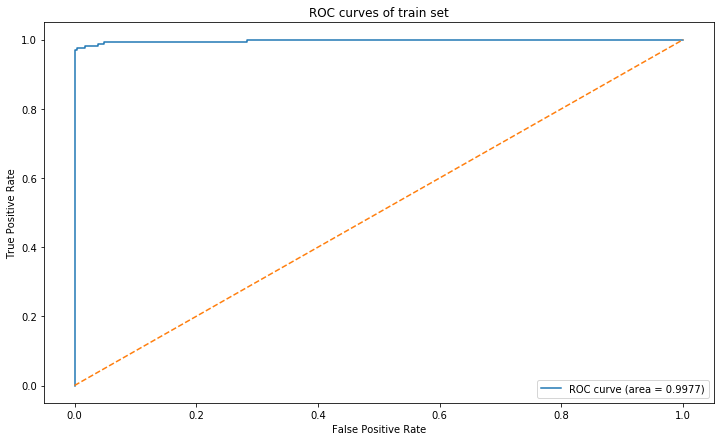

In [8]:
conf_mat = confusion_matrix(trainY, trainPredY)
print("The confusion for train set is \n{}".format(conf_mat))
fpr, tpr, thresholds = roc_curve(trainY, trainPredY_prob, pos_label=1)
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc_train)
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curves of train set")
plt.show()

The confusion for test set is 
[[70  1]
 [ 5 37]]


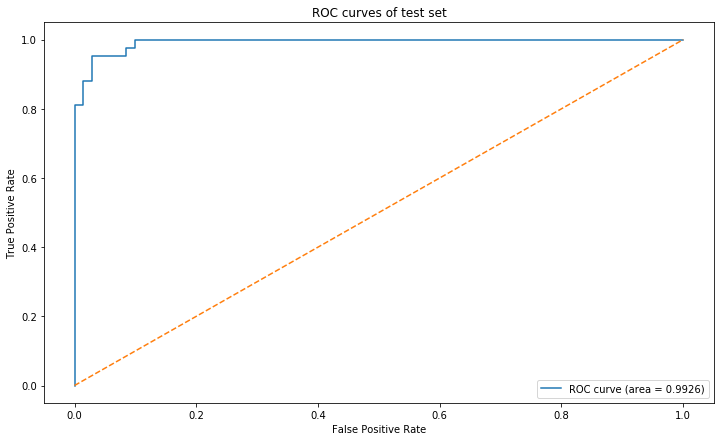

In [9]:
conf_mat = confusion_matrix(testY, testPredY)
print("The confusion for test set is \n{}".format(conf_mat))
fpr, tpr, thresholds = roc_curve(testY, testPredY_prob, pos_label=1)
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc_test)
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curves of test set")
plt.show()

In [10]:
# average metrics
train_resdf = train_resdf.apply(lambda x: x.mean(), axis=0)
test_resdf = test_resdf.apply(lambda x: x.mean(), axis=0)
print('\nSummary of average metrics')
print('-' * 80)
summary = pd.concat([train_resdf, test_resdf], axis=1)
summary = summary.T
summary = summary.set_index(pd.Series(['training', 'test']))
print(summary)


Summary of average metrics
--------------------------------------------------------------------------------
          accuracy  precision    recall  f1-score       auc
training  0.985599   0.990406  0.970784  0.985562  0.997799
test      0.968732   0.979646  0.935714  0.968532  0.992086


## b(ii)

In [11]:
def SemiSupervisedSVM(trainX, trainY, settings):
    labeled_idx = []
    #random choose 50% class 0 and 50% class 1
    for c in [0, 1]:
        c_idx, = np.where(trainY == c)
        idx_num = round(len(c_idx) * 0.5)
        select_idx = np.random.choice(c_idx, idx_num, replace=False)
        labeled_idx.extend(select_idx)
    unlabeled_idx = [i for i in range(len(trainX)) if i not in labeled_idx]
    
    labeledX = trainX[labeled_idx].tolist()
    labeledY = trainY.iloc[labeled_idx].tolist()
    unlabeledX = trainX[unlabeled_idx].tolist()
    unlabeledY = trainY.iloc[unlabeled_idx].tolist()
    # find the best parameter with given 50% data
    clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **settings)
    clf.fit(labeledX, labeledY)
    
    while len(unlabeledX) > 0:
        # find the best parameter with given 50% data
        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **settings)
        clf.fit(labeledX, labeledY)
        # calculate distance from unlabeled data points to decision boundary
        scores = clf.decision_function(unlabeledX)
        # sort by the absolute value of score
        sorted_idx = sorted([i for i in range(len(unlabeledX))], 
                            key=lambda x : abs(scores[x]),reverse = True)
        selected_idx = sorted_idx[0]
        svm_labeled_y = clf.predict(np.array(unlabeledX[selected_idx]).reshape(1, -1))
        
        # remove the farthest point from unlabeled and add the svm-predicted label to labeled
        labeledX.append(unlabeledX.pop(selected_idx))
        unlabeledY.pop(selected_idx)
        labeledY.append(svm_labeled_y[0]) #add an element not array
    
    return clf

In [12]:
tuned_params = {'C' : np.logspace(-2, 7, 20)}
    
#ettings of grid search
settings = {
    'param_grid' : tuned_params, 
    'scoring' : 'f1_weighted',
    'n_jobs' : -1,
    'verbose' : 0}

#initialize result dataframe
train_resdf = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score', 'auc'])
test_resdf = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score', 'auc'])

In [13]:
# 30 times Monte-Carlo Simulation
for i in range(30):
    trainX, trainY, testX, testY = split_train_test(wdbc_data, random_state=i)
    trainX, testX = normalize(trainX, testX)

    #5-fold cross-validation
    settings['cv'] = StratifiedKFold(5, random_state=i, shuffle=True)
    clf = SemiSupervisedSVM(trainX, trainY, settings)

    # predict and evaluate the model
    trainPredY_prob = clf.decision_function(trainX)
    trainPredY = clf.predict(trainX)
    acc_train = accuracy_score(trainY, trainPredY)
    precision = precision_score(trainY, trainPredY, pos_label=1)
    recall = recall_score(trainY, trainPredY, pos_label=1)
    f1score = f1_score(trainY, trainPredY, pos_label=1, average='weighted')
    auc_train = roc_auc_score(trainY, trainPredY_prob)
    tmp_train_result = {
        'accuracy' : acc_train,
        'precision' : precision,
        'recall' : recall,
        'f1-score' : f1score,
        'auc' : auc_train}
    train_resdf = train_resdf.append(tmp_train_result, ignore_index=True)

    testPredY_prob = clf.decision_function(testX)
    testPredY = clf.predict(testX)
    acc_test = accuracy_score(testY, testPredY)
    precision = precision_score(testY, testPredY, pos_label=1)
    recall = recall_score(testY, testPredY, pos_label=1)
    f1score = f1_score(testY, testPredY, pos_label=1, average='weighted')
    auc_test = roc_auc_score(testY, testPredY_prob)
    tmp_test_result = {
        'accuracy' : acc_test,
        'precision' : precision,
        'recall' : recall,
        'f1-score' : f1score,
        'auc' : auc_test}
    test_resdf = test_resdf.append(tmp_test_result, ignore_index=True)

    # output the best option
    print("Simulation {} -- Train accuracy : {:.4f}, Test accuracy : {:.4f}".format(i+1, acc_train,acc_test))
    print("The best parameter setting is:")
    print(clf.best_params_, "\n")

Simulation 1 -- Train accuracy : 0.9715, Test accuracy : 0.9735
The best parameter setting is:
{'C': 2.3357214690901213} 

Simulation 2 -- Train accuracy : 0.9715, Test accuracy : 0.9823
The best parameter setting is:
{'C': 20.69138081114788} 

Simulation 3 -- Train accuracy : 0.9825, Test accuracy : 0.9469
The best parameter setting is:
{'C': 2.3357214690901213} 

Simulation 4 -- Train accuracy : 0.9868, Test accuracy : 0.9381
The best parameter setting is:
{'C': 0.7847599703514611} 

Simulation 5 -- Train accuracy : 0.9759, Test accuracy : 0.9735
The best parameter setting is:
{'C': 2.3357214690901213} 

Simulation 6 -- Train accuracy : 0.9781, Test accuracy : 0.9469
The best parameter setting is:
{'C': 0.7847599703514611} 

Simulation 7 -- Train accuracy : 0.9737, Test accuracy : 0.9646
The best parameter setting is:
{'C': 0.7847599703514611} 

Simulation 8 -- Train accuracy : 0.9759, Test accuracy : 0.9469
The best parameter setting is:
{'C': 20.69138081114788} 

Simulation 9 -- Tr

The confusion for train set is 
[[286   0]
 [  7 163]]


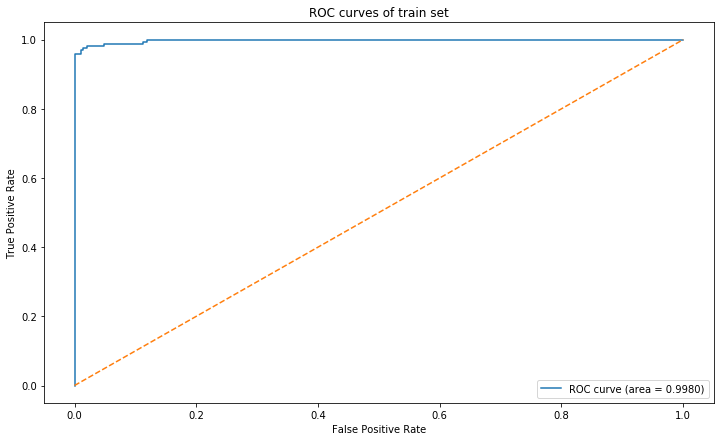

In [14]:
conf_mat = confusion_matrix(trainY, trainPredY)
print("The confusion for train set is \n{}".format(conf_mat))
fpr, tpr, thresholds = roc_curve(trainY, trainPredY_prob, pos_label=1)
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc_train)
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curves of train set")
plt.show()

The confusion for test set is 
[[69  2]
 [ 9 33]]


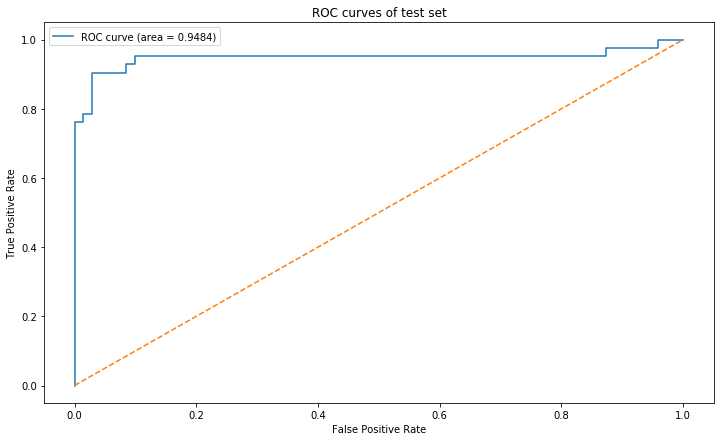

In [15]:
conf_mat = confusion_matrix(testY, testPredY)
print("The confusion for test set is \n{}".format(conf_mat))
fpr, tpr, thresholds = roc_curve(testY, testPredY_prob, pos_label=1)
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc_test)
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curves of test set")
plt.show()

In [16]:
# average metrics
train_resdf = train_resdf.apply(lambda x: x.mean(), axis=0)
test_resdf = test_resdf.apply(lambda x: x.mean(), axis=0)
print('\nSummary of average metrics')
print('-' * 80)
summary = pd.concat([train_resdf, test_resdf], axis=1)
summary = summary.T
summary = summary.set_index(pd.Series(['training', 'test']))
print(summary)


Summary of average metrics
--------------------------------------------------------------------------------
          accuracy  precision    recall  f1-score       auc
training  0.977266   0.985339  0.953333  0.977176  0.994748
test      0.961947   0.975415  0.921429  0.961634  0.988900


## b(iii)

In [17]:
#initialize result dataframe
train_resdf = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score', 'auc'])
test_resdf = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score', 'auc'])

In [18]:
# 30 times Monte-Carlo simulations
for i in range(30):
    trainX, trainY, testX, testY = split_train_test(wdbc_data, random_state=i)
    trainX, testX = normalize(trainX, testX)
    kmeans = KMeans(n_clusters=2, n_init=200, random_state=i)
    cluster_label_train = kmeans.fit_predict(trainX)
    cluster_label_test = kmeans.predict(testX)
    dist_to_center_train = kmeans.transform(trainX)
    dist_to_center_test = kmeans.transform(testX)
    
    s = list(enumerate(dist_to_center_train))
    close_to_0 = sorted(s, key = lambda x: x[1][0])[:30]
    close_to_1 = sorted(s, key = lambda x: x[1][1])[:30]
    indices_0 = [x[0] for x in close_to_0]
    indices_1 = [x[0] for x in close_to_1]
    mode_0 = mode(trainY.iloc[indices_0]) #majority poll : notice that cluster 0 may have majorirty of class 1
    mode_1 = mode(trainY.iloc[indices_1])
    
    #relabel
    cluster_label_train = np.where(cluster_label_train==0, mode_0, mode_1)
    cluster_label_test = np.where(cluster_label_test==0, mode_0, mode_1)
    
    # predict and evaluate the model
    if mode_0 == 0:
        trainPredY_prob = [softmax(dist_to_center_train[i])[0]  for i in range(dist_to_center_train.shape[0])] #probability of predicting as class 0
    else:
        trainPredY_prob = [softmax(dist_to_center_train[i])[1]  for i in range(dist_to_center_train.shape[0])] #probability of predicting as class 0
    trainPredY = cluster_label_train
    acc_train = accuracy_score(trainY, trainPredY)
    precision = precision_score(trainY, trainPredY, pos_label=1)
    recall = recall_score(trainY, trainPredY, pos_label=1)
    f1score = f1_score(trainY, trainPredY, pos_label=1, average='weighted')
    auc_train = roc_auc_score(trainY, trainPredY_prob)
    tmp_train_result = {
        'accuracy' : acc_train,
        'precision' : precision,
        'recall' : recall,
        'f1-score' : f1score,
        'auc' : auc_train}
    train_resdf = train_resdf.append(tmp_train_result, ignore_index=True)

    if mode_0 == 0:
        testPredY_prob = [softmax(dist_to_center_test[i])[0]  for i in range(dist_to_center_test.shape[0])] #probability of predicting as class 0
    else:
        testPredY_prob = [softmax(dist_to_center_test[i])[1]  for i in range(dist_to_center_test.shape[0])] #probability of predicting as class 0
    testPredY = cluster_label_test
    acc_test = accuracy_score(testY, testPredY)
    precision = precision_score(testY, testPredY, pos_label=1)
    recall = recall_score(testY, testPredY, pos_label=1)
    f1score = f1_score(testY, testPredY, pos_label=1, average='weighted')
    auc_test = roc_auc_score(testY, testPredY_prob)
    tmp_test_result = {
        'accuracy' : acc_test,
        'precision' : precision,
        'recall' : recall,
        'f1-score' : f1score,
        'auc' : auc_test}
    test_resdf = test_resdf.append(tmp_test_result, ignore_index=True)

    # output the best option
    print("Simulation {} -- Train accuracy : {:.4f}, Test accuracy : {:.4f}".format(i+1, acc_train,acc_test))

Simulation 1 -- Train accuracy : 0.9189, Test accuracy : 0.9469
Simulation 2 -- Train accuracy : 0.9276, Test accuracy : 0.9204
Simulation 3 -- Train accuracy : 0.9298, Test accuracy : 0.9027
Simulation 4 -- Train accuracy : 0.9342, Test accuracy : 0.9204
Simulation 5 -- Train accuracy : 0.9145, Test accuracy : 0.9469
Simulation 6 -- Train accuracy : 0.9298, Test accuracy : 0.9115
Simulation 7 -- Train accuracy : 0.9276, Test accuracy : 0.9292
Simulation 8 -- Train accuracy : 0.9211, Test accuracy : 0.8938
Simulation 9 -- Train accuracy : 0.9342, Test accuracy : 0.8938
Simulation 10 -- Train accuracy : 0.9276, Test accuracy : 0.9115
Simulation 11 -- Train accuracy : 0.9189, Test accuracy : 0.9381
Simulation 12 -- Train accuracy : 0.9211, Test accuracy : 0.9646
Simulation 13 -- Train accuracy : 0.9145, Test accuracy : 0.9469
Simulation 14 -- Train accuracy : 0.9189, Test accuracy : 0.9292
Simulation 15 -- Train accuracy : 0.9254, Test accuracy : 0.8938
Simulation 16 -- Train accuracy : 

The confusion for train set is 
[[276  10]
 [ 24 146]]


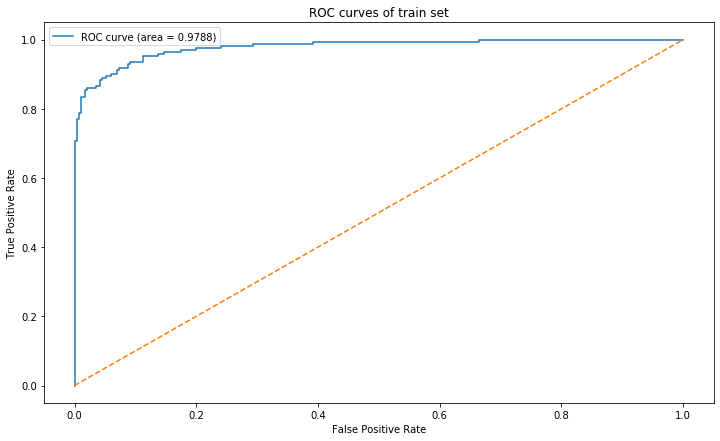

In [19]:
conf_mat = confusion_matrix(trainY, trainPredY)
print("The confusion for train set is \n{}".format(conf_mat))
fpr, tpr, thresholds = roc_curve(trainY, trainPredY_prob, pos_label=1)
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc_train)
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curves of train set")
plt.show()

The confusion for test set is 
[[69  2]
 [ 8 34]]


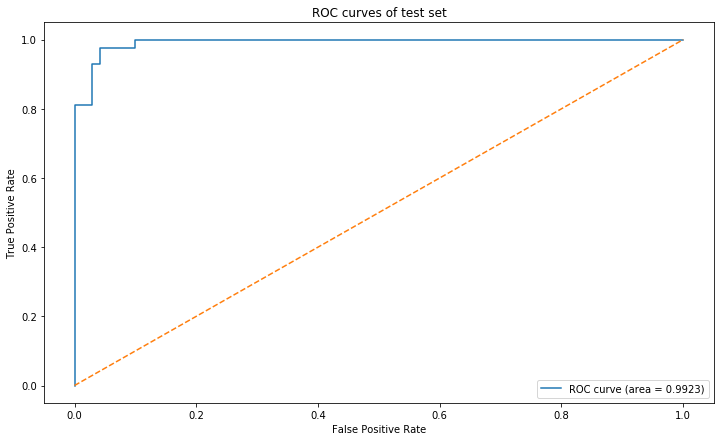

In [20]:
conf_mat = confusion_matrix(testY, testPredY)
print("The confusion for test set is \n{}".format(conf_mat))
fpr, tpr, thresholds = roc_curve(testY, testPredY_prob, pos_label=1)
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc_test)
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curves of test set")
plt.show()

In [21]:
# average metrics
train_resdf = train_resdf.apply(lambda x: x.mean(), axis=0)
test_resdf = test_resdf.apply(lambda x: x.mean(), axis=0)
print('\nSummary of average metrics')
print('-' * 80)
summary = pd.concat([train_resdf, test_resdf], axis=1)
summary = summary.T
summary = summary.set_index(pd.Series(['training', 'test']))
print(summary)


Summary of average metrics
--------------------------------------------------------------------------------
          accuracy  precision    recall  f1-score       auc
training  0.924561   0.946286  0.845882  0.923597  0.980165
test      0.925369   0.949875  0.844444  0.924219  0.980170


## b(iv)

In [22]:
#initialize result dataframe
train_resdf = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score', 'auc'])
test_resdf = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score', 'auc'])

In [23]:
# 30 times Monte-Carlo simulations
for i in range(30):
    trainX, trainY, testX, testY = split_train_test(wdbc_data, random_state=i)
    trainX, testX = normalize(trainX, testX)
    spec_clust = SpectralClustering(affinity = 'rbf',
                                gamma = 1,
                                n_clusters=2,
                                n_init=100,
                                random_state=i)
    cluster_label_train = spec_clust.fit_predict(trainX)

    #majority polling by entire points in the train clusters
    indices_0 = np.where(cluster_label_train==0)
    indices_0_num = len(indices_0[0])
    indices_1 = np.where(cluster_label_train==1)
    indices_1_num = len(indices_1[0])
    mode_0 = mode(trainY.iloc[indices_0])
    indices_0_class_0 = len(trainY.iloc[indices_0][trainY==0])
    mode_1 = mode(trainY.iloc[indices_1])
    indices_1_class_0 = len(trainY.iloc[indices_1][trainY==0])
    cluster_label_train = np.where(cluster_label_train==0, mode_0, mode_1)
    
    #generate probability
    trainY = trainY.to_frame()
    trainY.loc[trainY.iloc[indices_0].index,'prob'] = trainY.apply(lambda x: 1-indices_0_class_0/indices_0_num,axis=1)
    trainY.loc[trainY.iloc[indices_1].index,'prob'] = trainY.apply(lambda x: 1-indices_1_class_0/indices_1_num,axis=1)
    trainPredY_prob = trainY['prob']
    trainY = trainY['label']
    
    #use a KNN for prediction for test data
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(trainX, cluster_label_train)

    # predict and evaluate the model
    trainPredY = cluster_label_train
    acc_train = accuracy_score(trainY, trainPredY)
    precision = precision_score(trainY, trainPredY, pos_label=1)
    recall = recall_score(trainY, trainPredY, pos_label=1)
    f1score = f1_score(trainY, trainPredY, pos_label=1, average='weighted')
    auc_train = roc_auc_score(trainY, trainPredY_prob)
    tmp_train_result = {
        'accuracy' : acc_train,
        'precision' : precision,
        'recall' : recall,
        'f1-score' : f1score,
        'auc' : auc_train}
    train_resdf = train_resdf.append(tmp_train_result, ignore_index=True)

    
    testPredY = knn.predict(testX)
    testPredY_prob = knn.predict_proba(testX)[:,[1]]
    acc_test = accuracy_score(testY, testPredY)
    precision = precision_score(testY, testPredY, pos_label=1)
    recall = recall_score(testY, testPredY, pos_label=1)
    f1score = f1_score(testY, testPredY, pos_label=1, average='weighted')
    auc_test = roc_auc_score(testY, testPredY_prob)
    tmp_test_result = {
        'accuracy' : acc_test,
        'precision' : precision,
        'recall' : recall,
        'f1-score' : f1score,
        'auc' : auc_test}
    test_resdf = test_resdf.append(tmp_test_result, ignore_index=True)

    # output the best option
    print("Simulation {} -- Train accuracy : {:.4f}, Test accuracy : {:.4f}".format(i+1, acc_train,acc_test))

Simulation 1 -- Train accuracy : 0.8662, Test accuracy : 0.8938
Simulation 2 -- Train accuracy : 0.8618, Test accuracy : 0.8850
Simulation 3 -- Train accuracy : 0.8838, Test accuracy : 0.8673
Simulation 4 -- Train accuracy : 0.8640, Test accuracy : 0.8230
Simulation 5 -- Train accuracy : 0.8553, Test accuracy : 0.8850
Simulation 6 -- Train accuracy : 0.8640, Test accuracy : 0.8584
Simulation 7 -- Train accuracy : 0.8596, Test accuracy : 0.8673
Simulation 8 -- Train accuracy : 0.8246, Test accuracy : 0.8142
Simulation 9 -- Train accuracy : 0.8333, Test accuracy : 0.8053
Simulation 10 -- Train accuracy : 0.8553, Test accuracy : 0.8850
Simulation 11 -- Train accuracy : 0.8311, Test accuracy : 0.8761
Simulation 12 -- Train accuracy : 0.8553, Test accuracy : 0.8850
Simulation 13 -- Train accuracy : 0.8794, Test accuracy : 0.9115
Simulation 14 -- Train accuracy : 0.8531, Test accuracy : 0.8407
Simulation 15 -- Train accuracy : 0.8575, Test accuracy : 0.8496
Simulation 16 -- Train accuracy : 

The confusion for train set is 
[[284   2]
 [ 56 114]]


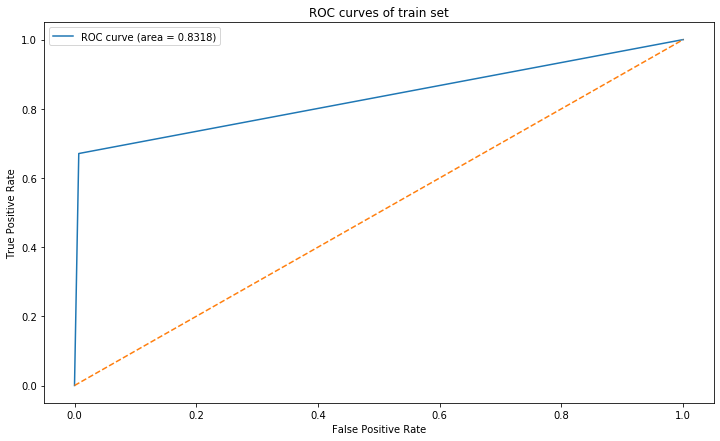

In [24]:
conf_mat = confusion_matrix(trainY, trainPredY)
print("The confusion for train set is \n{}".format(conf_mat))
fpr, tpr, thresholds = roc_curve(trainY, trainPredY_prob, pos_label=1)
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc_train)
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curves of train set")
plt.show()

The confusion for test set is 
[[71  0]
 [17 25]]


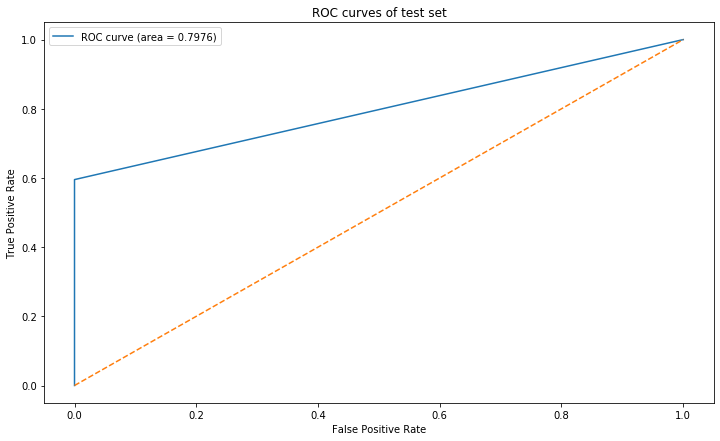

In [25]:
conf_mat = confusion_matrix(testY, testPredY)
print("The confusion for test set is \n{}".format(conf_mat))
fpr, tpr, thresholds = roc_curve(testY, testPredY_prob, pos_label=1)
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc_test)
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curves of test set")
plt.show()

In [26]:
# average metrics
train_resdf = train_resdf.apply(lambda x: x.mean(), axis=0)
test_resdf = test_resdf.apply(lambda x: x.mean(), axis=0)
print('\nSummary of average metrics')
print('-' * 80)
summary = pd.concat([train_resdf, test_resdf], axis=1)
summary = summary.T
summary = summary.set_index(pd.Series(['training', 'test']))
print(summary)


Summary of average metrics
--------------------------------------------------------------------------------
          accuracy  precision    recall  f1-score       auc
training  0.857310   0.982714  0.628431  0.848347  0.810894
test      0.863422   0.992532  0.638095  0.854101  0.817404


## b(v)

### According to the performance report above, we can observe that the performance comparison of different training strategies is : supervised > semi-simpervised > unsupervised, which is expected. It is observed that the supervised learning on the full data set performs similarly to the semi-supervised learning with half of the data set labeled. Theoretically, the former is supposed to work better than the later one. However, this could happen by chance because the number of Monte-Carlo Simulations for each classifiers is only performed a relatively small time. The gap between supervised and semi-supaervised is sinificantly smaller than that between (semi-)supervised cases and unsupervised cases. Those supervised case will have more information of labels to guide their learning while the prediction of unsupervised ones is just based on the similarity of features.

## 2

## (a)

In [4]:
banknote_data_path = '../data/data_banknote_authentication.txt'
banknote_data = pd.read_csv(banknote_data_path, header = None)
banknote_data.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

In [5]:
banknote_data

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [6]:
def split_train_test_v2(data, random_state):
    test_size=472
    np.random.seed(random_state)
    
    test_idx = np.random.choice(data.shape[0], 472, replace=False)
    train_idx = np.array([i for i in range(data.shape[0]) if i not in test_idx])

    trainX = data.iloc[train_idx, :-1].copy()
    trainY = data.iloc[train_idx, -1].copy()
    testX = data.iloc[test_idx, :-1].copy()
    testY = data.iloc[test_idx, -1].copy()
    
    return trainX, trainY, testX, testY

trainX, trainY, testX, testY = split_train_test_v2(banknote_data, 10)

In [7]:
trainX

,variance,skewness,curtosis,entropy
0,3.62160,8.66610,-2.80730,-0.44699
2,3.86600,-2.63830,1.92420,0.10645
3,3.45660,9.52280,-4.01120,-3.59440
4,0.32924,-4.45520,4.57180,-0.98880
5,4.36840,9.67180,-3.96060,-3.16250
...,...,...,...,...
1366,-2.41000,3.74330,-0.40215,-1.29530
1367,0.40614,1.34920,-1.45010,-0.55949
1368,-1.38870,-4.87730,6.47740,0.34179
1369,-3.75030,-13.45860,17.59320,-2.77710


## b(i)

In [15]:
def passiveLearning(trainX, trainY, testX, testY, settings):
    touse_idx = np.arange(trainX.shape[0])
    used_idx = []
    error_list = []
    
    while len(touse_idx) > 0:
        # randomly get pool of 10 samples
        np.random.shuffle(touse_idx)
        pool, touse_idx = touse_idx[:10], touse_idx[10:]
        used_idx.extend(pool)
        
        # get new training set and apply cross-validation
        used_trainX, used_trainY = trainX[used_idx], trainY.iloc[used_idx]
        
        # build and fit the grid search for given classifier
        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **settings)
        clf.fit(used_trainX, used_trainY)
        
        # evaluate on test
        testPredY = clf.predict(testX)
        error = 1- accuracy_score(testY, testPredY)
        error_list.append(error)
    
    return error_list

In [16]:
tuned_params = {'C' : np.logspace(-2, 7, 20)}
settings = {
    'param_grid' : tuned_params, 
    'scoring' : 'f1_weighted',
    'n_jobs' : -1,
    'verbose' : 0
}

passive_learning_curve = []

for i in range(50):
    # randomly split data
    trainX, trainY, testX, testY = split_train_test_v2(banknote_data, random_state=i)

    # normalize training/test data
    trainX, testX = normalize(trainX, testX)
    
    settings['cv'] = StratifiedKFold(5, random_state=i, shuffle=True)

    error_list = passiveLearning(trainX, trainY, testX, testY, settings)
    passive_learning_curve.append(error_list)

    # output the best option
    print("Simulation {} -- Test error with 10 samples: {:.4f}, Test error with 900 samples: {:.4f}".format(i+1, error_list[0], error_list[-1]))
passive_learning_curve = np.array(passive_learning_curve)
passive_learning_curve = np.mean(passive_learning_curve, axis=0)

Simulation 1 -- Test error with 10 samples: 0.1780, Test error with 900 samples: 0.0148
Simulation 2 -- Test error with 10 samples: 0.3008, Test error with 900 samples: 0.0127
Simulation 3 -- Test error with 10 samples: 0.1886, Test error with 900 samples: 0.0233
Simulation 4 -- Test error with 10 samples: 0.0424, Test error with 900 samples: 0.0085
Simulation 5 -- Test error with 10 samples: 0.0530, Test error with 900 samples: 0.0191
Simulation 6 -- Test error with 10 samples: 0.1398, Test error with 900 samples: 0.0085
Simulation 7 -- Test error with 10 samples: 0.1462, Test error with 900 samples: 0.0042
Simulation 8 -- Test error with 10 samples: 0.4131, Test error with 900 samples: 0.0191
Simulation 9 -- Test error with 10 samples: 0.4936, Test error with 900 samples: 0.0212
Simulation 10 -- Test error with 10 samples: 0.1292, Test error with 900 samples: 0.0148
Simulation 11 -- Test error with 10 samples: 0.1335, Test error with 900 samples: 0.0064
Simulation 12 -- Test error wi

## b(ii)

In [20]:
def activeLearning(trainX, trainY, testX, testY, settings):
    touse_idx = np.arange(trainX.shape[0])
    used_idx = []
    error_list = []
    
    # initially randomly get pool of 10 samples
    np.random.shuffle(touse_idx)
    pool = touse_idx[:10]
    while trainY.iloc[pool].sum()== 0 or 10: # ensure that it will contain two class in 10 samples
        np.random.shuffle(touse_idx) 
        pool = touse_idx[:10]
    touse_idx =  touse_idx[10:]
    used_idx.extend(pool)
    
    while len(used_idx) <= 900:
        # get new training set and apply cross-validation
        used_trainX, used_trainY = trainX[used_idx], trainY.iloc[used_idx]
        
        # build and fit the grid search for given classifier
        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **settings)
        clf.fit(used_trainX, used_trainY)
        
        # evaluate on test
        testPredY = clf.predict(testX)
        error = 1- accuracy_score(testY, testPredY)
        error_list.append(error)
        
        # select the most closest 10 points
        dist = clf.decision_function(trainX[touse_idx])
        sortedarg = np.arange(len(touse_idx))   
        sorted(sortedarg, key=lambda i : abs(dist[i])) #sorted index of dist-list
        touse_idx = touse_idx[sortedarg]
        pool, touse_idx = touse_idx[:10], touse_idx[10:]
        used_idx.extend(pool)
        
    return error_list

In [21]:
tuned_params = {'C' : np.logspace(-2, 7, 20)}
settings = {
    'param_grid' : tuned_params, 
    'scoring' : 'f1_weighted',
    'n_jobs' : -1,
    'verbose' : 0
}

active_learning_curve = []

for i in range(50):
    # randomly split data
    trainX, trainY, testX, testY = split_train_test_v2(banknote_data, random_state=i)

    # normalize training/test data
    trainX, testX = normalize(trainX, testX)
    
    settings['cv'] = StratifiedKFold(5, random_state=i, shuffle=True)

    error_list = passiveLearning(trainX, trainY, testX, testY, settings)
    active_learning_curve.append(error_list)

    # output the best option
    print("Simulation {} -- Test error with 10 samples: {:.4f}, Test error with 900 samples: {:.4f}".format(i+1, error_list[0], error_list[-1]))
active_learning_curve = np.array(active_learning_curve)
active_learning_curve = np.mean(active_learning_curve, axis=0)

Simulation 1 -- Test error with 10 samples: 0.1780, Test error with 900 samples: 0.0148
Simulation 2 -- Test error with 10 samples: 0.3008, Test error with 900 samples: 0.0127
Simulation 3 -- Test error with 10 samples: 0.1886, Test error with 900 samples: 0.0233
Simulation 4 -- Test error with 10 samples: 0.0424, Test error with 900 samples: 0.0085
Simulation 5 -- Test error with 10 samples: 0.0530, Test error with 900 samples: 0.0212
Simulation 6 -- Test error with 10 samples: 0.1398, Test error with 900 samples: 0.0085
Simulation 7 -- Test error with 10 samples: 0.1462, Test error with 900 samples: 0.0042
Simulation 8 -- Test error with 10 samples: 0.4131, Test error with 900 samples: 0.0191
Simulation 9 -- Test error with 10 samples: 0.4936, Test error with 900 samples: 0.0212
Simulation 10 -- Test error with 10 samples: 0.1292, Test error with 900 samples: 0.0148
Simulation 11 -- Test error with 10 samples: 0.1335, Test error with 900 samples: 0.0064
Simulation 12 -- Test error wi

## (c)

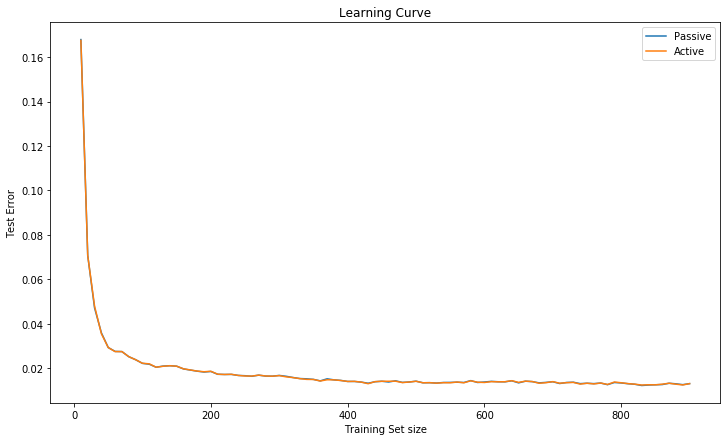

In [22]:
x = 10 * np.arange(1, 91)
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(x, passive_learning_curve, label='Passive')
axes.plot(x, active_learning_curve, label='Active')
axes.set_xlabel("Training Set size")
axes.set_ylabel("Test Error")
axes.legend()
axes.set_title("Learning Curve")
plt.show()